# Лабораторна робота №2
Тема: Оглядовий аналіз та візуалізація даних (EDA)  
Студент: Луцюк Богдан КН-2  
Варіант: 4 / [https://www.kaggle.com/...](https://www.kaggle.com/datasets/ahsan81/superstore-marketing-campaign-dataset)  
Дата: 22.10.2025  
Репозиторій: https://github.com/emissuu/UniTasks/tree/main/R/Lab2

## Init and general overview

In [1]:
install.packages("vcd")
install.packages("corrplot")
install.packages("car")
library(dplyr)
library(corrplot)
library(ggplot2)
library(vcd)
library(car)  

seed <- 16
analysis_date <- as.Date("2015-01-01")

data <- read.csv("data\\data.csv")
cat("General data overview:\n")
glimpse(data)
cat("\nNA cases count:", sum(is.na(data)))
cat("\nNA in income field:", sum(is.na(data$Income)))
cat("\nDuplicates count:", sum(duplicated(data[, -which(names(data) == "Id")])))


Installing package into ‘C:/Users/Meri/AppData/Local/R/win-library/4.5’
(as ‘lib’ is unspecified)


trying URL 'https://cran.rstudio.com/bin/windows/contrib/4.5/vcd_1.4-13.zip'
Content type 'application/zip' length 1305962 bytes (1.2 MB)
downloaded 1.2 MB



package ‘vcd’ successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Meri\AppData\Local\Temp\Rtmpq0zuX3\downloaded_packages
Installing package into ‘C:/Users/Meri/AppData/Local/R/win-library/4.5’
(as ‘lib’ is unspecified)


trying URL 'https://cran.rstudio.com/bin/windows/contrib/4.5/corrplot_0.95.zip'
Content type 'application/zip' length 3826012 bytes (3.6 MB)
downloaded 3.6 MB



package ‘corrplot’ successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Meri\AppData\Local\Temp\Rtmpq0zuX3\downloaded_packages
Installing package into ‘C:/Users/Meri/AppData/Local/R/win-library/4.5’
(as ‘lib’ is unspecified)


trying URL 'https://cran.rstudio.com/bin/windows/contrib/4.5/car_3.1-3.zip'
Content type 'application/zip' length 1541133 bytes (1.5 MB)
downloaded 1.5 MB



package ‘car’ successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Meri\AppData\Local\Temp\Rtmpq0zuX3\downloaded_packages

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Warning message:
package ‘dplyr’ was built under R version 4.5.1 


corrplot 0.95 loaded


Warning message:
package ‘corrplot’ was built under R version 4.5.2 


Loading required package: grid


Warning message:
package ‘vcd’ was built under R version 4.5.2 


Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode



Warning messages:
1: package ‘car’ was built under R version 4.5.2 
2: package ‘carData’ was built under R version 4.5.1 


General data overview:
Rows: 2,240
Columns: 22
$ Id                  <int> 1826, 1, 10476, 1386, 5371, 7348, 4073, 1991, 4047…
$ Year_Birth          <int> 1970, 1961, 1958, 1967, 1989, 1958, 1954, 1967, 19…
$ Education           <chr> "Graduation", "Graduation", "Graduation", "Graduat…
$ Marital_Status      <chr> "Divorced", "Single", "Married", "Together", "Sing…
$ Income              <int> 84835, 57091, 67267, 32474, 21474, 71691, 63564, 4…
$ Kidhome             <int> 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,…
$ Teenhome            <int> 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,…
$ Dt_Customer         <chr> "6/16/2014", "6/15/2014", "5/13/2014", "11/5/2014"…
$ Recency             <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ MntWines            <int> 189, 464, 134, 10, 6, 336, 769, 78, 384, 384, 450,…
$ MntFruits           <int> 104, 5, 11, 0, 16, 130, 80, 0, 0, 0, 26, 4, 82, 10…
$ MntMeatProducts     <int> 379, 64, 59, 1, 24, 411, 252, 11, 102, 102, 5

## Little cleaning

In [15]:
# Cleaning duplicates
data_clean <- data |>
  distinct(across(-Id), .keep_all = TRUE)

# Parsing dates
data_clean <- data_clean |>
  mutate(
    Dt_Customer = as.Date(Dt_Customer, format = "%m/%d/%Y")
  )

# Meaning incomes
data_clean <- data_clean |>
  mutate(
    Income = if_else(!is.na(Income), Income, as.integer(mean(data_clean$Income, na.rm = TRUE)))
  )

# Adding some new characteristics
data_clean <- data_clean |>
  mutate(
    Age = as.integer(format(analysis_date, "%Y")) - Year_Birth,
    MntTotal = MntWines + MntFruits + MntMeatProducts + MntFishProducts + MntSweetProducts + MntGoldProds,
    NumTotalPurchases = NumWebPurchases + NumCatalogPurchases + NumStorePurchases,
    DaysCustomer = as.integer(analysis_date - Dt_Customer),
    HasChildren = as.logical(ifelse(Kidhome > 0 | Teenhome > 0, 1, 0)),
    TotalChildren = Kidhome + Teenhome
  ) 

# Cleaning outliers
data_clean <- data_clean |>
  mutate(
    Income = if_else(Income < 150000, Income, as.integer(mean(data_clean$Income))),
    Age = if_else(Age < 110, Age, as.integer(mean(data_clean$Age)))
  )

# Merging marital status
data_clean <- data_clean |>
  mutate(
    Marital_Status = if_else(Marital_Status %in% c("Single", "Married", "Widow", "Together", "Divorced"), Marital_Status, "Single")
  )

data_clean$Response <- factor(data_clean$Response, labels = c("No", "Yes"))


write.csv(data_clean, "data\\data_clean.csv", row.names = FALSE)
glimpse(data_clean)

Rows: 2,058
Columns: 28
$ Id                  <int> 1826, 1, 10476, 1386, 5371, 7348, 4073, 1991, 4047…
$ Year_Birth          <int> 1970, 1961, 1958, 1967, 1989, 1958, 1954, 1967, 19…
$ Education           <chr> "Graduation", "Graduation", "Graduation", "Graduat…
$ Marital_Status      <chr> "Divorced", "Single", "Married", "Together", "Sing…
$ Income              <int> 84835, 57091, 67267, 32474, 21474, 71691, 63564, 4…
$ Kidhome             <int> 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,…
$ Teenhome            <int> 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,…
$ Dt_Customer         <date> 2014-06-16, 2014-06-15, 2014-05-13, 2014-11-05, 2…
$ Recency             <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ MntWines            <int> 189, 464, 134, 10, 6, 336, 769, 78, 384, 450, 140,…
$ MntFruits           <int> 104, 5, 11, 0, 16, 130, 80, 0, 0, 26, 4, 82, 10, 4…
$ MntMeatProducts     <int> 379, 64, 59, 1, 24, 411, 252, 11, 102, 535, 61, 44…
$ MntFishProduct

## Basic analysis
### Age

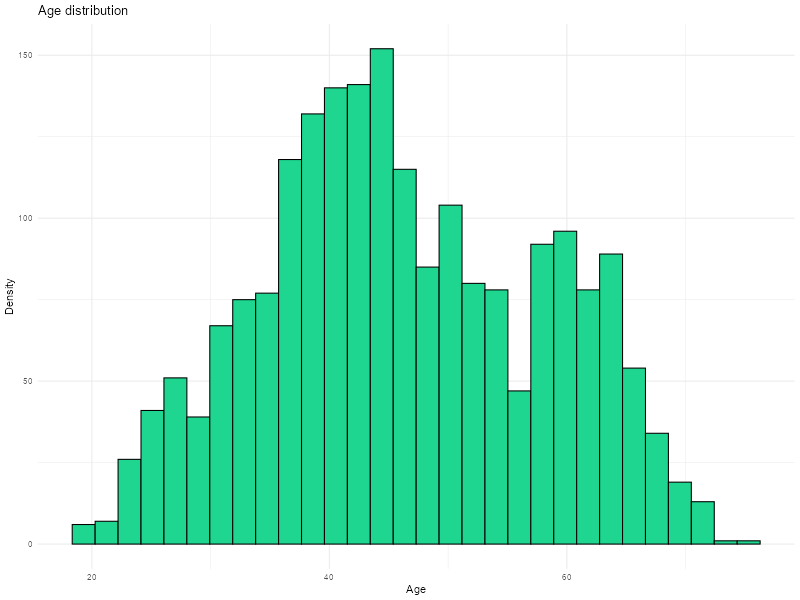

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

In [24]:
ggplot(data_clean, aes(x = Age)) +
  geom_histogram(fill = "#1ED68F", color = "black") +
  labs(title = "Age distribution", x = "Age", y = "Density") +
  theme_minimal()

### Education

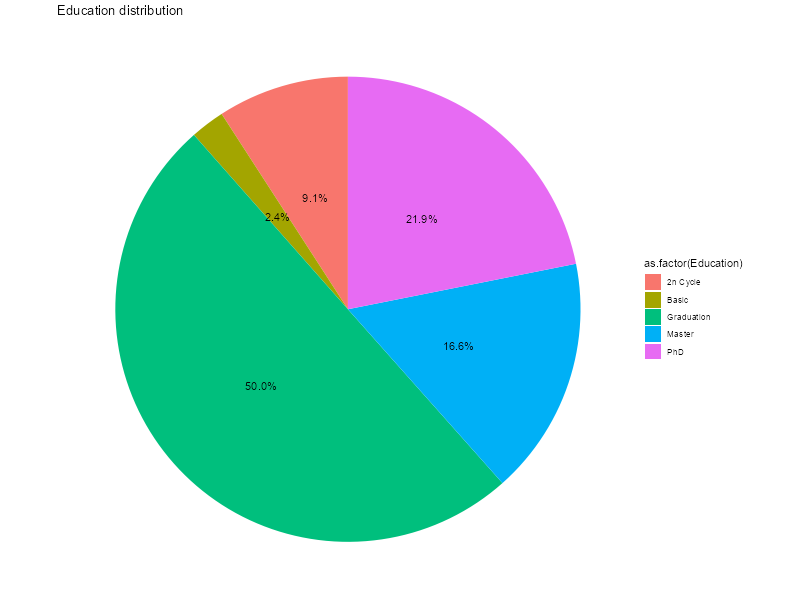

In [25]:
ggplot(data_clean, aes(x = "", fill = as.factor(Education))) +
  geom_bar(width = 1) +
  coord_polar(theta = "y") +
  labs(title = "Education distribution") +
  geom_text(aes(label = scales::percent(..count../sum(..count..))), stat = "count", position = position_stack(vjust = 0.5)) +
  theme_void()

### Marital status distribution

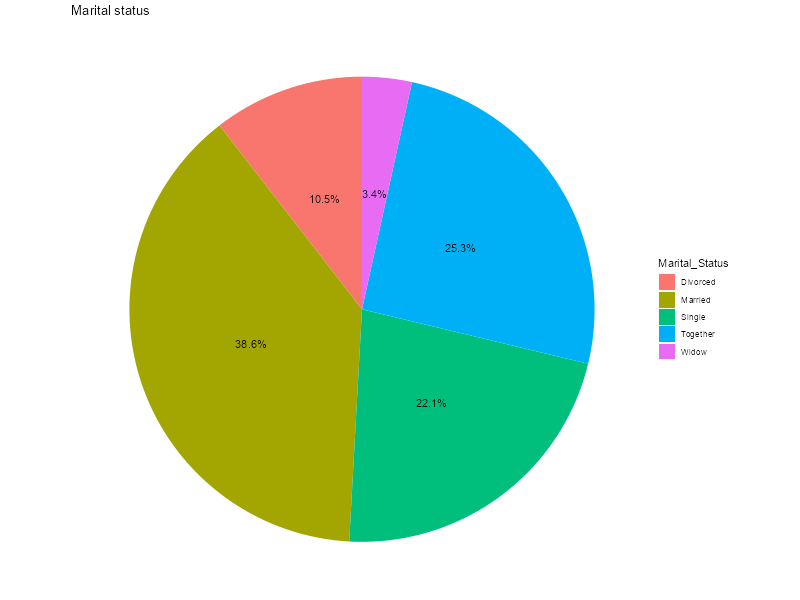

In [26]:
ggplot(data_clean, aes(x = "", fill = Marital_Status)) +
  geom_bar(width = 1) +
  coord_polar(theta = "y") +
  labs(title = "Marital status") +
  geom_text(aes(label = scales::percent(..count../sum(..count..))), stat = "count", position = position_stack(vjust = 0.5)) +
  theme_void()

### Monthly new customers

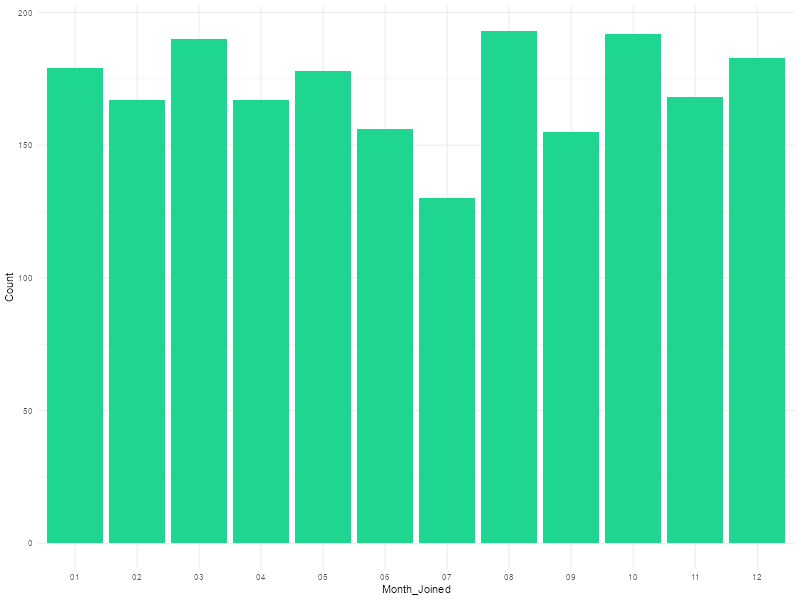

In [27]:
data_clean |>
  mutate(
    Month_Joined = as.factor(format(Dt_Customer, "%m"))
  ) |>
  group_by(Month_Joined) |>
  summarise(
    Count = n()
  ) |>
  ggplot(aes(x = Month_Joined, y = Count)) +
  geom_bar(fill = "#1ED68F", stat = "Identity") +
  theme_minimal()

## Correlation
### Pearson method

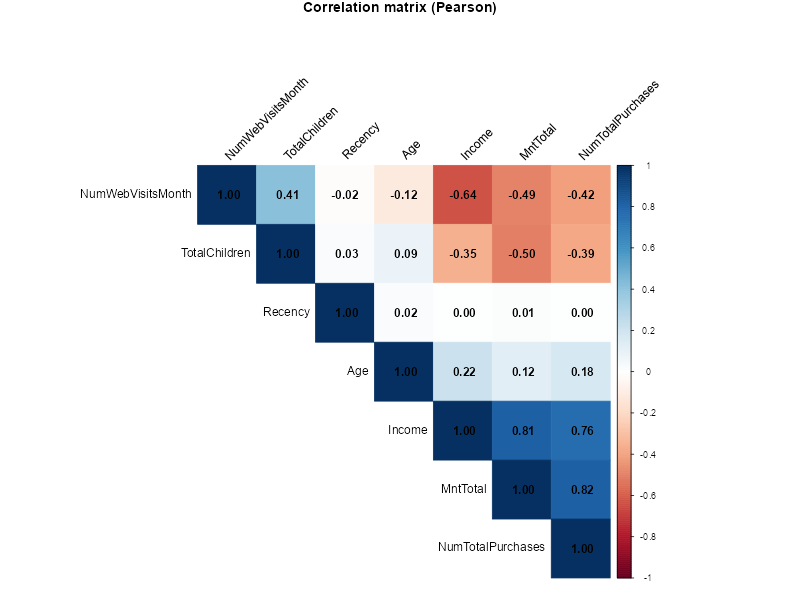

In [138]:
numeric_columns <- data_clean |>
  select_if(is.numeric)

cor_matrix <- cor(numeric_vars, method = "pearson")
corrplot(cor_matrix, method = "color", type = "upper", order = "hclust",
         addCoef.col = "black", tl.col = "black", tl.srt = 45,
         title = "Correlation matrix (Pearson)", mar=c(0,0,1,0))

### Spearman method

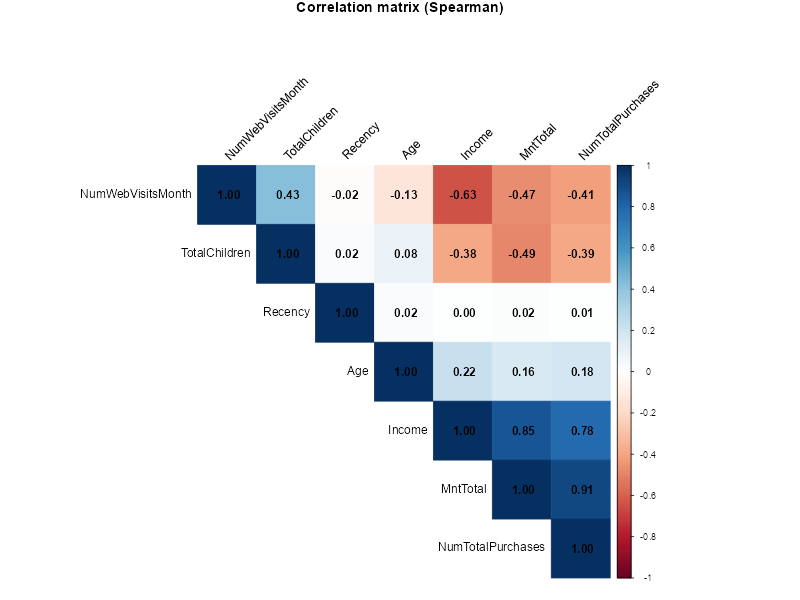

In [139]:
numeric_columns <- data_clean |>
  select_if(is.numeric)

cor_matrix <- cor(numeric_vars, method = "spearman")
corrplot(cor_matrix, method = "color", type = "upper", order = "hclust",
         addCoef.col = "black", tl.col = "black", tl.srt = 45,
         title = "Correlation matrix (Spearman)", mar=c(0,0,1,0))

### Cramer's V

In [55]:
print(assocstats(table(data_clean$Education, data_clean$Marital_Status)))

                    X^2 df P(> X^2)
Likelihood Ratio 17.107 16  0.37873
Pearson          16.448 16  0.42213

Phi-Coefficient   : NA 
Contingency Coeff.: 0.089 
Cramer's V        : 0.045 


## Analysis of the targeted column 
### Response column variation

Warning message:
The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(count)` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


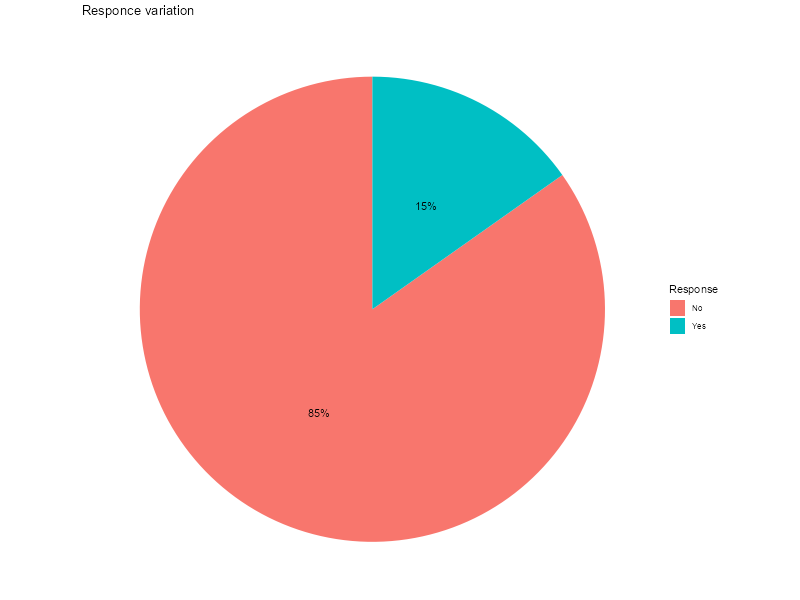

In [16]:
data_clean <- data_clean |>
  mutate(Response = factor(Response, labels = c("No", "Yes")))

ggplot(data_clean, aes(x = "", fill = Response)) +
  geom_bar(width = 1) +
  coord_polar(theta = "y") +
  labs(title = "Responce variation") +
  geom_text(aes(label = scales::percent(..count../sum(..count..))), stat = "count", position = position_stack(vjust = 0.5)) +
  theme_void()

### Amount of bought total and response

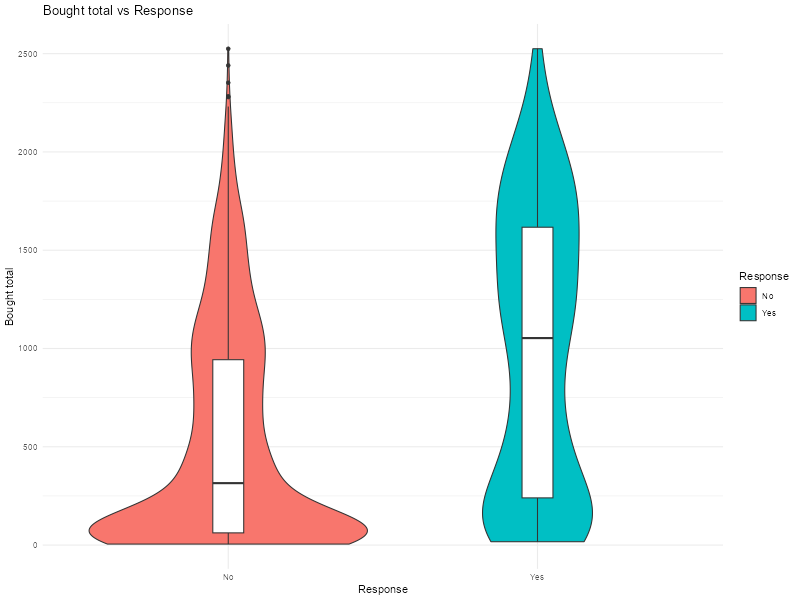

In [17]:
ggplot(data_clean, aes(x = Response, y = MntTotal, fill = Response)) +
  geom_violin() +
  geom_boxplot(width = 0.1, fill = "white") +
  labs(title = "Bought total vs Response", x = "Response", y = "Bought total") +
  theme_minimal()

### Income and responses

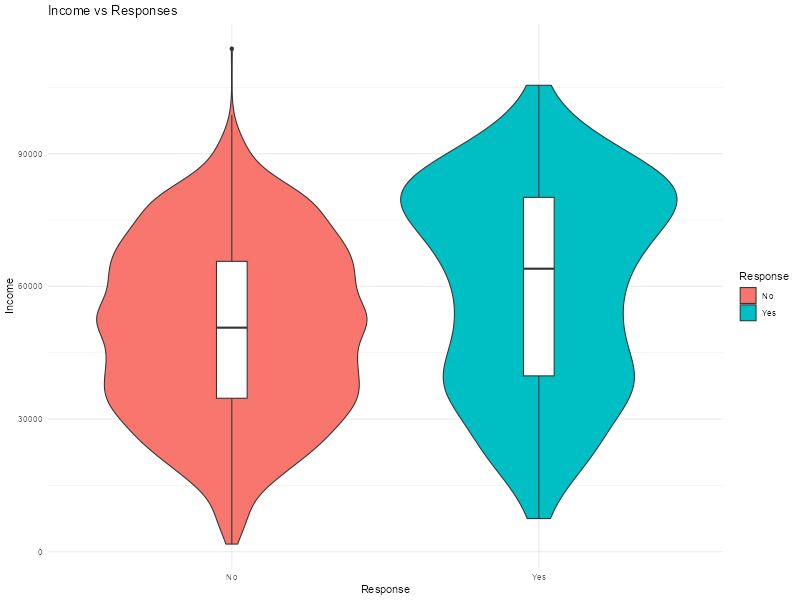

In [18]:
ggplot(data_clean, aes(x = Response, y = Income, fill = Response)) +
  geom_violin() +
  geom_boxplot(width = 0.1, fill = "white") +
  labs(title = "Income vs Responses", x = "Response", y = "Income") +
  theme_minimal()

### Days since purchase and responses

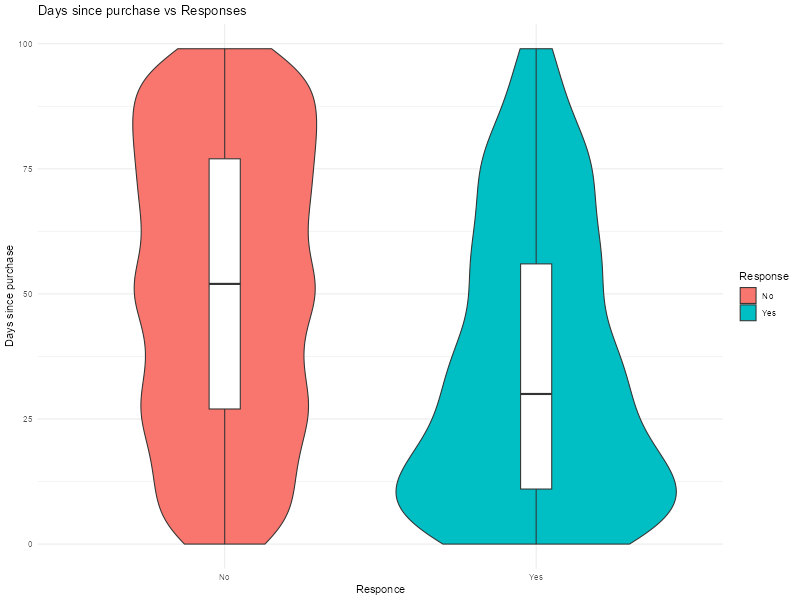

In [19]:
ggplot(data_clean, aes(x = Response, y = Recency, fill = Response)) +
  geom_violin() +
  geom_boxplot(width = 0.1, fill = "white") +
  labs(title = "Days since purchase vs Responses",
       x = "Responce", y = "Days since purchase") +
  theme_minimal()

### Fraction of responses by education

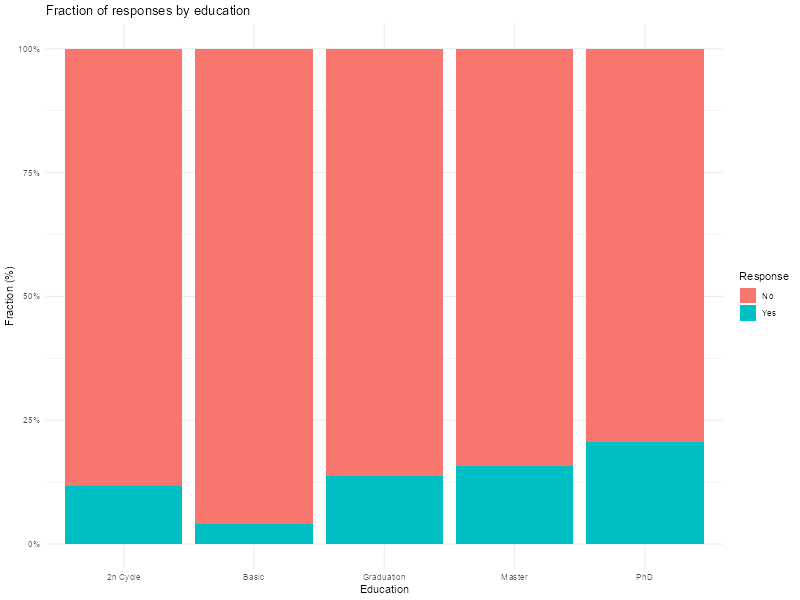

In [20]:
ggplot(data_clean, aes(x = Education, fill = Response)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = scales::percent) +
  labs(title = "Fraction of responses by education",
       x = "Education", y = "Fraction (%)") +
  theme_minimal()

### Fraction of responses by kids amount

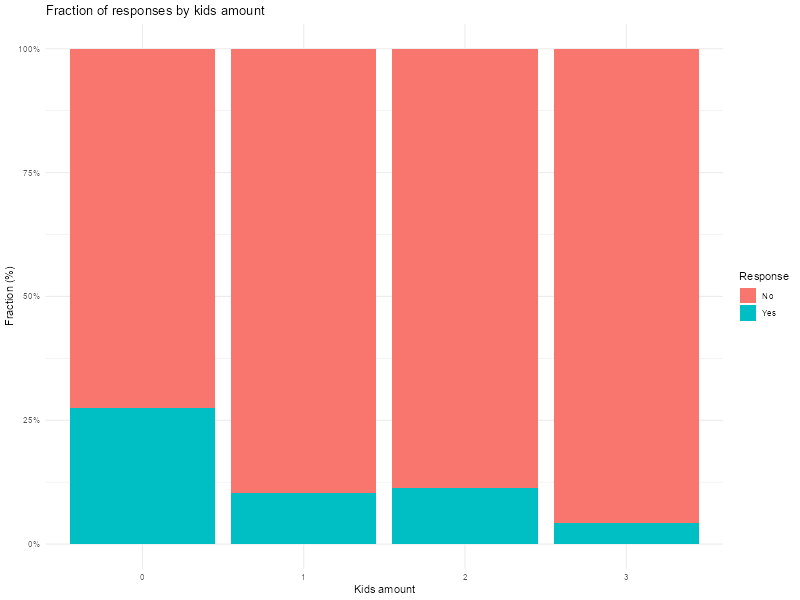

In [21]:
ggplot(data_clean, aes(x = factor(TotalChildren), fill = Response)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = scales::percent) +
  labs(title = "Fraction of responses by kids amount",
       x = "Kids amount", y = "Fraction (%)") +
  theme_minimal()

### Point-Biserial correlation with responses

In [22]:
response_numeric <- ifelse(data_clean$Response == "Yes", 1, 0)
cor_with_target <- cor(
  data_clean |> select(Age, Income, Recency, MntTotal, NumTotalPurchases, NumWebVisitsMonth) |> na.omit(), 
  response_numeric[complete.cases(data_clean %>% select(Age, Income, Recency, MntTotal, NumTotalPurchases, NumWebVisitsMonth))]
)
cat("Point-Biserial correlation with response\n")
print(sort(cor_with_target[,1], decreasing = TRUE))
rm(response_numeric)

Point-Biserial correlation with response
         MntTotal            Income NumTotalPurchases NumWebVisitsMonth 
      0.262637399       0.173826285       0.162317151      -0.002815036 
              Age           Recency 
     -0.022977439      -0.202877444 


### Cramér's V correlation with responses

In [23]:
cat("Cramér's V correlation with response\n\n")
cat("- Education and response:\n")
print(assocstats(table(data_clean$Education, data_clean$Response)))
cat("\n- Marital status and response:\n")
print(assocstats(table(data_clean$Marital_Status, data_clean$Response)))

Cramér's V correlation with response

- Education and response:
                    X^2 df   P(> X^2)
Likelihood Ratio 19.545  4 0.00061411
Pearson          18.612  4 0.00093670

Phi-Coefficient   : NA 
Contingency Coeff.: 0.095 
Cramer's V        : 0.095 

- Marital status and response:
                    X^2 df   P(> X^2)
Likelihood Ratio 46.425  4 2.0091e-09
Pearson          48.580  4 7.1431e-10

Phi-Coefficient   : NA 
Contingency Coeff.: 0.152 
Cramer's V        : 0.154 


## Facets and groups

### Money spent on wine and income (divided by marital status and response)

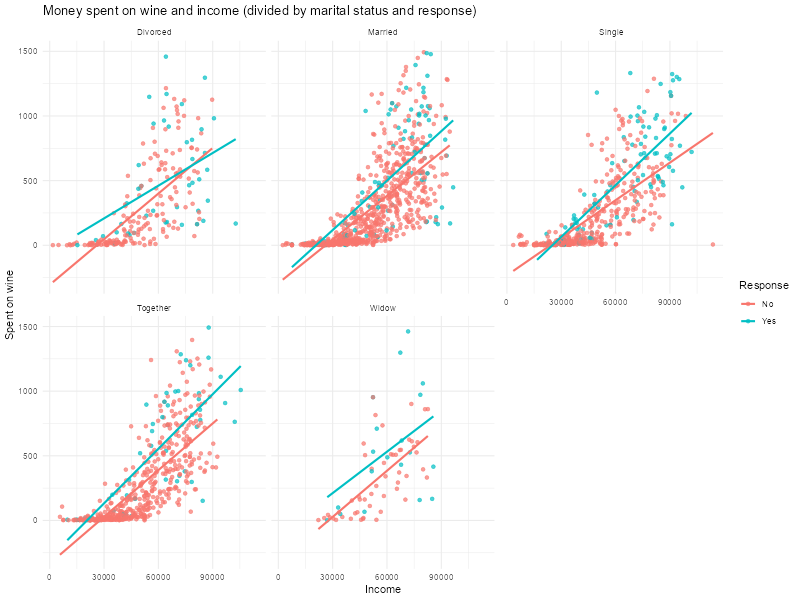

`geom_smooth()` using formula = 'y ~ x'

In [28]:
ggplot(data_clean, aes(x = Income, y = MntWines, color = Response)) +
  geom_point(alpha = 0.7) +
  geom_smooth(method = "lm", se = FALSE) +
  facet_wrap(~ Marital_Status) +
  labs(title = "Money spent on wine and income (divided by marital status and response)",
       x = "Income", y = "Spent on wine") +
  theme_minimal()

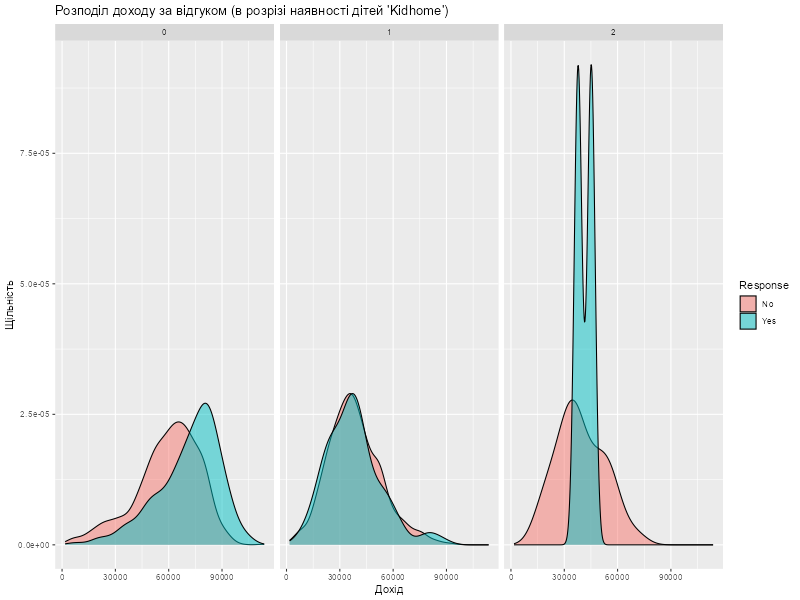

In [ ]:
ggplot(data_clean, aes(x = Income, fill = Response)) +
  geom_density(alpha = 0.5) +
  facet_wrap(~ Kidhome) +
  labs(title = "Income by response (divide dby kidhome count)",
       x = "Income", y = "Density")